In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.models

from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

from PIL import ImageFile

e:\python\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'E:\python\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 设置调用GPU，如果有GPU就调用GPU，如果没有GPU则调用CPU训练模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [3]:
# 1.transforms.Compose()对图像进行各种转换操作，并用函数compose()将这些转换操作组合起来；
# 2.transforms.RandomResizedCrop(224)将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为指定的大小；
# （即先随机采集，然后对裁剪得到的图像缩放为同一大小）
# 3.transforms.RandomHorizontalFlip()以给定的概率随机水平旋转给定的PIL的图像，默认概率为0.5；
# 4.transforms.ToTensor()将给定图像转为Tensor形式
# 5.transforms.Normalize()对数据进行归一化处理
# 6.transforms.Resize([h, w])指定图片的高宽大小

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(120),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((120, 120)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}
# train_data = torchvision.datasets.CIFAR10(root = "./data" , train = True , download = True) # 获取Alexnet的实验数据集CIFAR10
#  

In [4]:
# 1.torch.utils.data.DataLoader(object)：
# dataset：指定数据集,batch_size：每个batch有多少样本,shuffle：在每个epoch开始的时候，对数据进行重新排序
# num_workers(int, optional): 决定了有几个进程来处理data loading。0意味着所有的数据都会被load进主进程来处理。
# windows系统下，num_workers设置为0，linux系统下可以设置多进程；

def Data_preprocessing():
    # 训练集
    train_data = torchvision.datasets.ImageFolder(root = "./data/train" ,   transform = data_transform["train"]) 
    traindata = DataLoader(dataset= train_data , batch_size= 128 , shuffle= True , num_workers=0)
    
    # 验证集
    test_data = torchvision.datasets.ImageFolder(root = "./data/val" , transform = data_transform["val"])
    testdata = DataLoader(dataset = test_data , batch_size= 128 , shuffle= True , num_workers=0 )
    # test_data = torchvision.datasets.CIFAR10(root = "./data" , train = False ,download = False,
    #                                           transform = trans) # 获取AlexNet的实验数据集CIFAR10, 测试集or验证集

    train_size = len(train_data) # 测试集图片数目
    test_size = len(test_data) # 验证集图片数目
    print(train_size)
    print(test_size)
   

    return traindata, testdata

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet , self).__init__() # 集成nn.Module的初始化方式
        self.model = nn.Sequential(
            # 每个样本input[3,120,120] output[48,29,29]  
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  #二维卷积(1) input[3, 224, 224]  output[48, 55, 55] 
            nn.ReLU(inplace=True), # 激活函数，对输出进行处理
            # output[48,14,14] 
            nn.MaxPool2d(kernel_size=3, stride=2),  #最大池化(1) output[48, 27, 27]
            # output[128,14,14]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),  #二维卷积(2) output[128, 27, 27]
            nn.ReLU(inplace=True), # 激活函数，对输出进行处理
            # output[128,6,6]
            nn.MaxPool2d(kernel_size=3, stride=2),  #最大池化(2) output[128, 13, 13]
            # output[192,6,6]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),  #二维卷积(3) output[192, 13, 13]
            nn.ReLU(inplace=True),  # 激活函数，对输出进行处理
            # output[192,6,6]
            nn.Conv2d(192, 192, kernel_size=3, padding=1),  #二维卷积(4) output[192, 13, 13]
            nn.ReLU(inplace=True), # 激活函数，对输出进行处理
            # output[128,6,6]
            nn.Conv2d(192, 128, kernel_size=3, padding=1),  #二维卷积(5) output[128, 13, 13]
            nn.ReLU(inplace=True), # 激活函数，对输出进行处理
            # output[128,2,2]
            nn.MaxPool2d(kernel_size=3, stride=2),  #最大池化(3) output[128, 6, 6]
            # output[128*2*2]
            nn.Flatten(),  # 展平，即降维成一维, output[128*6*6]
            nn.Dropout(p=0.5), # 随机丢失，概率为0.5
            # output[2048]
            nn.Linear(512, 2048), # 全连接层(1) [128*6*6,2048] 
            nn.ReLU(inplace=True), # 激活函数，对输出进行处理
            nn.Dropout(p=0.5), # 随机丢失，概率为0.5
            # output[1024]
            nn.Linear(2048, 1024),  # 全连接层(2) [2048,1024] 
            nn.ReLU(inplace=True),  # 激活函数，对输出进行处理
            # output[7]
            nn.Linear(1024, 2), # 全连接层(2) [1024,1000] 

        )
    def forward(self , x): # 前向传播
        x = self.model(x)
        return x

In [6]:
def model_train(alexnet, traindata, testdata, epoch=100):
    learning = 0.001 # 学习率
    optimizer = torch.optim.Adam(alexnet.parameters(), lr = learning) # 优化器
    loss = nn.CrossEntropyLoss() # 损失函数，交叉熵损失

    train_loss_all = [] # 训练集损失
    train_accur_all = [] # 训练集准确率
    test_loss_all = [] # 验证集损失
    test_accur_all = [] # 验证集准确率

    for i in range(epoch): # 开始迭代
        train_loss = 0
        train_num = 0.0
        train_accuracy = 0.0
        alexnet.train()
        train_bar = tqdm(traindata) # 进度条描述
        for step , data in enumerate(train_bar):
            img , target = data # img=x, target=y
            optimizer.zero_grad() # 将梯度初始化为零
            outputs = alexnet(img.to(device)) # 输出预测值

            loss1  = loss(outputs , target.to(device)) # 损失
            outputs = torch.argmax(outputs, 1) # 返回索引值
            loss1.backward() # 反向传播
            optimizer.step() # 优化，更新参数的值
            train_loss += abs(loss1.item())*img.size(0) # 单次迭代误差之和
            accuracy = torch.sum(outputs == target.to(device)) # 准确率
            train_accuracy = train_accuracy + accuracy # 单次迭代后的预测准确率
            train_num += img.size(0) # 总样本数目

        print("epoch：{} ， train-Loss：{} , train-accuracy：{}".format(i+1 , train_loss/train_num , train_accuracy/train_num))
        train_loss_all.append(train_loss/train_num)
        train_accur_all.append(train_accuracy.double().item()/train_num)

        test_loss = 0
        test_accuracy = 0.0
        test_num = 0
        alexnet.eval()
        with torch.no_grad():
            test_bar = tqdm(testdata)
            for data in test_bar:
                img , target = data

                outputs = alexnet(img.to(device))

                loss2 = loss(outputs, target.to(device))
                outputs = torch.argmax(outputs, 1)
                test_loss = test_loss + abs(loss2.item())*img.size(0)
                accuracy = torch.sum(outputs == target.to(device))
                test_accuracy = test_accuracy + accuracy
                test_num += img.size(0)

        print("test-Loss：{} , test-accuracy：{}".format(test_loss / test_num, test_accuracy / test_num))
        test_loss_all.append(test_loss/test_num)
        test_accur_all.append(test_accuracy.double().item()/test_num)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1 , 2 , 1)
    plt.plot(range(epoch) , train_loss_all,
             "ro-",label = "Train loss")
    plt.plot(range(epoch), test_loss_all,
             "bs-",label = "test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(range(epoch) , train_accur_all,
             "ro-",label = "Train accur")
    plt.plot(range(epoch) , test_accur_all,
             "bs-",label = "test accur")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

    torch.save(alexnet.state_dict(), "alexnet.pth") # 保存模型参数权重

    print("模型已保存")

    return

  0%|          | 0/5 [00:00<?, ?it/s]

517
58


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：1 ， train-Loss：0.70284402762437 , train-accuracy：0.5338491201400757


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7237374782562256 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：2 ， train-Loss：0.6954069899636496 , train-accuracy：0.4990328848361969


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.69652259349823 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：3 ， train-Loss：0.6935588229786266 , train-accuracy：0.4816247820854187


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6899718642234802 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：4 ， train-Loss：0.692966658787755 , train-accuracy：0.4719536006450653


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6965200901031494 , test-accuracy：0.2931034564971924


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：5 ， train-Loss：0.6934278572781635 , train-accuracy：0.5048356056213379


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7015865445137024 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：6 ， train-Loss：0.6935167580093591 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6835900545120239 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：7 ， train-Loss：0.6932957552848978 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6795032620429993 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：8 ， train-Loss：0.6930333004698762 , train-accuracy：0.4990328848361969


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6899387836456299 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：9 ， train-Loss：0.6924026641901042 , train-accuracy：0.5261121988296509


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.692123532295227 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：10 ， train-Loss：0.692950254943892 , train-accuracy：0.5241779685020447


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7001025676727295 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：11 ， train-Loss：0.6939102415881719 , train-accuracy：0.5029013752937317


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7087904214859009 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：12 ， train-Loss：0.6928875939758419 , train-accuracy：0.5067698359489441


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6930922865867615 , test-accuracy：0.48275861144065857


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：13 ， train-Loss：0.6922109738078753 , train-accuracy：0.5299806594848633


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6848189234733582 , test-accuracy：0.6206896305084229


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：14 ， train-Loss：0.6900353950504178 , train-accuracy：0.5570600032806396


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6825351119041443 , test-accuracy：0.6379310488700867


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：15 ， train-Loss：0.6899200839276932 , train-accuracy：0.5551257133483887


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6953107714653015 , test-accuracy：0.41379308700561523


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：16 ， train-Loss：0.6912736838514154 , train-accuracy：0.5261121988296509


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7043613791465759 , test-accuracy：0.3103448152542114


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

epoch：17 ， train-Loss：0.6914395985105282 , train-accuracy：0.5241779685020447


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6888476610183716 , test-accuracy：0.5517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：18 ， train-Loss：0.6927558518009445 , train-accuracy：0.5125725269317627


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6750972867012024 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：19 ， train-Loss：0.6893734285171996 , train-accuracy：0.5551257133483887


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6933262944221497 , test-accuracy：0.5


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：20 ， train-Loss：0.686895428473991 , train-accuracy：0.5512572526931763


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6680178046226501 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：21 ， train-Loss：0.6889132623285112 , train-accuracy：0.5377176403999329


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6642791628837585 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：22 ， train-Loss：0.696047696430863 , train-accuracy：0.5164410471916199


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6666647791862488 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：23 ， train-Loss：0.6938114353028672 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6842376589775085 , test-accuracy：0.7068965435028076


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：24 ， train-Loss：0.6881360970797806 , train-accuracy：0.5512572526931763


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6805434823036194 , test-accuracy：0.7068965435028076


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：25 ， train-Loss：0.689581538307367 , train-accuracy：0.5338491201400757


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6646636724472046 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：26 ， train-Loss：0.6958634709251227 , train-accuracy：0.5415861010551453


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.702058732509613 , test-accuracy：0.36206895112991333


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：27 ， train-Loss：0.6993630220627185 , train-accuracy：0.5357834100723267


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6548410058021545 , test-accuracy：0.7068965435028076


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：28 ， train-Loss：0.6867506346112293 , train-accuracy：0.5415861010551453


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7920089960098267 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：29 ， train-Loss：0.7250318189423596 , train-accuracy：0.4738878309726715


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6516713500022888 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：30 ， train-Loss：0.6981571947352337 , train-accuracy：0.5106382966041565


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.643229067325592 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：31 ， train-Loss：0.7019134427869343 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6825164556503296 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：32 ， train-Loss：0.7019665824606064 , train-accuracy：0.42940038442611694


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.709014892578125 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：33 ， train-Loss：0.6941701588824363 , train-accuracy：0.4700193703174591


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6918937563896179 , test-accuracy：0.568965494632721


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：34 ， train-Loss：0.6933745242640866 , train-accuracy：0.4893617033958435


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6898855566978455 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：35 ， train-Loss：0.6932084470468517 , train-accuracy：0.5067698359489441


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6922560930252075 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：36 ， train-Loss：0.6933290815445625 , train-accuracy：0.4932301938533783


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.691956102848053 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：37 ， train-Loss：0.6931476091508478 , train-accuracy：0.4912959635257721


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6895319819450378 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：38 ， train-Loss：0.6932413334772711 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6823927164077759 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：39 ， train-Loss：0.6928121938696221 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.678134560585022 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：40 ， train-Loss：0.6943210995174238 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.677216649055481 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：41 ， train-Loss：0.6933293731115773 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6763328313827515 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：42 ， train-Loss：0.6936291633768285 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6833423972129822 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：43 ， train-Loss：0.6935415367093262 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6864751577377319 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：44 ， train-Loss：0.6932902797278399 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6880992650985718 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：45 ， train-Loss：0.6931021317291998 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6880307197570801 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：46 ， train-Loss：0.6932052300100862 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6905186772346497 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：47 ， train-Loss：0.6932627880365752 , train-accuracy：0.4738878309726715


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.695248544216156 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：48 ， train-Loss：0.6932097199576505 , train-accuracy：0.4990328848361969


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6957828402519226 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：49 ， train-Loss：0.692985491780294 , train-accuracy：0.4970986545085907


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6941816806793213 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：50 ， train-Loss：0.6928127990239363 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6928668022155762 , test-accuracy：0.568965494632721


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：51 ， train-Loss：0.6928193972696419 , train-accuracy：0.5319148898124695


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6885257363319397 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：52 ， train-Loss：0.6929408832952179 , train-accuracy：0.5029013752937317


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6871440410614014 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：53 ， train-Loss：0.6930095493447619 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6868837475776672 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：54 ， train-Loss：0.6925107201478468 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6886841058731079 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：55 ， train-Loss：0.6923610320174256 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6904070377349854 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：56 ， train-Loss：0.6920645700432576 , train-accuracy：0.5783365964889526


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6918766498565674 , test-accuracy：0.6034482717514038


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：57 ， train-Loss：0.6909592194298941 , train-accuracy：0.6073501110076904


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6950048208236694 , test-accuracy：0.48275861144065857


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：58 ， train-Loss：0.691395992697784 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7014307975769043 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：59 ， train-Loss：0.6888075794887727 , train-accuracy：0.5415861010551453


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6869080066680908 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：60 ， train-Loss：0.6887032276657149 , train-accuracy：0.5880077481269836


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.681864321231842 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：61 ， train-Loss：0.686061257550518 , train-accuracy：0.5705996155738831


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6877060532569885 , test-accuracy：0.5862069129943848


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：62 ， train-Loss：0.686048285297084 , train-accuracy：0.5725338459014893


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6742706298828125 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：63 ， train-Loss：0.6814410035107537 , train-accuracy：0.5725338459014893


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6712685227394104 , test-accuracy：0.6379310488700867


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：64 ， train-Loss：0.6918986725622727 , train-accuracy：0.5280464291572571


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6852005124092102 , test-accuracy：0.6034482717514038


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：65 ， train-Loss：0.6945246338152563 , train-accuracy：0.5164410471916199


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6820212602615356 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：66 ， train-Loss：0.6916552557244292 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6946476697921753 , test-accuracy：0.517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：67 ， train-Loss：0.6938246915142126 , train-accuracy：0.4816247820854187


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.695704996585846 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：68 ， train-Loss：0.7025625703413205 , train-accuracy：0.5319148898124695


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6591872572898865 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：69 ， train-Loss：0.7063512662623791 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6658411622047424 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：70 ， train-Loss：0.6951810793673738 , train-accuracy：0.4932301938533783


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6883055567741394 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：71 ， train-Loss：0.6902906193723992 , train-accuracy：0.5415861010551453


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6850858330726624 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：72 ， train-Loss：0.6913892476886108 , train-accuracy：0.5357834100723267


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6853069067001343 , test-accuracy：0.6206896305084229


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：73 ， train-Loss：0.6892069093955093 , train-accuracy：0.5531914830207825


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6845479011535645 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：74 ， train-Loss：0.6895534720134919 , train-accuracy：0.5338491201400757


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6774404644966125 , test-accuracy：0.6379310488700867


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：75 ， train-Loss：0.68548110029453 , train-accuracy：0.5512572526931763


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7596249580383301 , test-accuracy：0.43103447556495667


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：76 ， train-Loss：0.6832360793589624 , train-accuracy：0.5841392874717712


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6407657861709595 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：77 ， train-Loss：0.7423691138538678 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6716908812522888 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：78 ， train-Loss：0.6904923563077325 , train-accuracy：0.5164410471916199


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7030590176582336 , test-accuracy：0.5517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：79 ， train-Loss：0.6913796741681126 , train-accuracy：0.5241779685020447


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6956483125686646 , test-accuracy：0.517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：80 ， train-Loss：0.6910845110448693 , train-accuracy：0.5222437381744385


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6750890612602234 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：81 ， train-Loss：0.6927164224637546 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.65224289894104 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：82 ， train-Loss：0.695889031979286 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.66871178150177 , test-accuracy：0.6896551847457886


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

epoch：83 ， train-Loss：0.6915489655398769 , train-accuracy：0.5009671449661255


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6836048364639282 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：84 ， train-Loss：0.6933482273173748 , train-accuracy：0.4970986545085907


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6842873692512512 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：85 ， train-Loss：0.6904245529691302 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6650225520133972 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：86 ， train-Loss：0.6913936270735942 , train-accuracy：0.5048356056213379


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6665757298469543 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：87 ， train-Loss：0.68031133039777 , train-accuracy：0.5976789593696594


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7665755152702332 , test-accuracy：0.32758620381355286


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：88 ， train-Loss：0.7007664787930723 , train-accuracy：0.5067698359489441


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7045052647590637 , test-accuracy：0.48275861144065857


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

epoch：89 ， train-Loss：0.6867628309666765 , train-accuracy：0.5454545617103577


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6743261814117432 , test-accuracy：0.6206896305084229


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：90 ， train-Loss：0.6880158909976598 , train-accuracy：0.5377176403999329


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6790524125099182 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：91 ， train-Loss：0.6779408823821255 , train-accuracy：0.582205057144165


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7821748852729797 , test-accuracy：0.5517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：92 ， train-Loss：0.6810025034375071 , train-accuracy：0.5725338459014893


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6687456965446472 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：93 ， train-Loss：0.677770135942234 , train-accuracy：0.6054158806800842


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6764819622039795 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：94 ， train-Loss：0.6793394530303705 , train-accuracy：0.5899419784545898


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6477693915367126 , test-accuracy：0.6206896305084229


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：95 ， train-Loss：0.6847093574544216 , train-accuracy：0.603481650352478


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6775965094566345 , test-accuracy：0.5517241358757019


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：96 ， train-Loss：0.6679534155810594 , train-accuracy：0.6073501110076904


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6795527935028076 , test-accuracy：0.6206896305084229


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：97 ， train-Loss：0.66782301122492 , train-accuracy：0.624758243560791


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6744766235351562 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：98 ， train-Loss：0.6591494828174377 , train-accuracy：0.646034836769104


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.6582176089286804 , test-accuracy：0.6551724076271057


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：99 ， train-Loss：0.6726216609288922 , train-accuracy：0.5783365964889526


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.5779624581336975 , test-accuracy：0.6724137663841248


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：100 ， train-Loss：0.6837101547584312 , train-accuracy：0.5628626942634583


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


test-Loss：0.7727950811386108 , test-accuracy：0.517241358757019


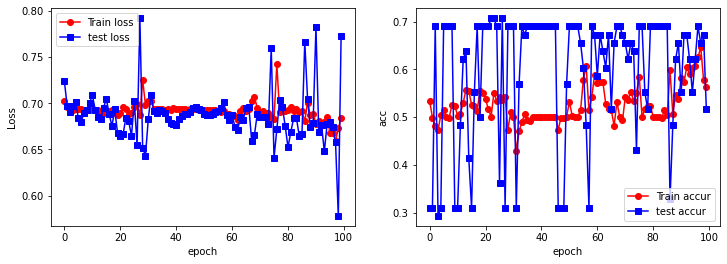

模型已保存


In [7]:
'''main'''
traindata, testdata = Data_preprocessing() # 数据预处理

alexnet = AlexNet() # AlexNet神经网络
# print(alexnet)
alexnet.to(device)

'''
# 前向传播测试
test1 = torch.ones(64, 3, 120, 120)
test1 = alexnet(test1.to(device))
print(test1.shape) # 输出测试结果
'''

epoch  = 100 # 迭代次数


model_train(alexnet, traindata, testdata, epoch)
# 保存的模型参数权重文件alexnet.pth 
